## Setup Project
Import used packages


In [1]:
# import required libraries
import os
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
import glob
import warnings
from sklearn import mixture
import itertools
import seaborn as sns

Setup global plot settings

In [2]:

# configure notebook for plotting
%pylab inline --no-import-all 
mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color'] # allows access to colours
# subsequent lines default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(20,20)  
matplotlib.rcParams['font.size']=16    
matplotlib.rcParams['savefig.dpi']= 300   
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


## Data entry and categorisation
Enter data file location and initiate variables

In [3]:

# import data from Data directory
allPointsFiles = glob.glob('../Data/*/*/points.txt')
allFuzzyFiles = glob.glob('../Data/*/*/fuzzy.txt')
allVaryingPointFiles = glob.glob('../Data/*/*/P*.csv')
allXrayFiles = glob.glob('../Data/XrayFlash.txt')
farPoints = []
midPoints = []
closePoints = []
variablePoints = []
xRayPoints = []
totalPoints = 0


### Categorise and process Points
Iterate through points files and categorize points into close and far points, where close points can be measured by parallax accurately.\
Convert to useful data types in process.\
                      0    1  2     3     4          5                    6                 7
points data format: [Name, x, y, parsec, HRx, Absolute magnitude, Apparent magnitude, Radial Velocity]

In [4]:
for j, pointsFile in enumerate(allPointsFiles):
    try:
        this = Table.read(pointsFile,format='ascii')
        totalPoints= totalPoints+len(this)
        thispar = this['par']
        thism0, thism1, thism2 = (np.log10(this['flux1']), 
                                  np.log10(this['flux2']), 
                                  np.log10(this['flux3']))
        thiscolour = thism2-thism0
        dist = 1/thispar
        abs_mag = thism1 + 2*np.log10(dist)
        
        # transform coords onto "sky net" based on file path and store in numpy array          
        if pointsFile.rfind('Up')!=-1:
            points = np.array([this['name'], this['y'], -this['x']+90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Front')!=-1:
            points = np.array([this['name'], this['y']-90, -this['x']+90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Right')!=-1:
            points = np.array([this['name'], this['x'], this['y'], thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Back')!=-1:
            points = np.array([this['name'], this['x']+90, this['y'], thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Left')!=-1:
            points = np.array([this['name'], this['y']-90, -this['x']+180, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
        elif pointsFile.rfind('Down')!=-1:
            points = np.array([this['name'], this['y'], -this['x']-90, thispar, thiscolour, abs_mag, thism1, this['rv']]).T.tolist()
            
        # sort into close and far
        for point in points:
            if float(point[3]) > 0.006:
                closePoints.append(point)
            elif float(point[3]) < 0.004:# value chosen to minimize clusters being assigned to mid distance
                farPoints.append(point)   
            else:
                midPoints.append(point)  
    except:
        pass
closePointsNumpy=np.array(closePoints)
midPointsNumpy=np.array(midPoints)
farPointsNumpy=np.array(farPoints)


allPointsNumpy=np.concatenate((closePointsNumpy, midPointsNumpy, farPointsNumpy))

## Variable points

In [5]:

for j, varsFile in enumerate(allVaryingPointFiles):
    
    try:
        thisVar = np.array(Table.read(varsFile,format='ascii'))
        name = varsFile[-10:-4]
        basicData=allPointsNumpy[allPointsNumpy[:,0]==name,[1,2,3,4,6]]
        variablePoint=np.array([name,thisVar,basicData[0],basicData[1],basicData[2],basicData[3],basicData[4]])
        variablePoints.append(variablePoint)
    except Exception as e:
        print('Failed: '+ str(e))
        print(varsFile[-10:-4])
        pass
variablePointsNumpy=np.array(variablePoints)

Failed: shape mismatch: indexing arrays could not be broadcast together with shapes (2,) (5,) 
P01003
Failed: shape mismatch: indexing arrays could not be broadcast together with shapes (2,) (5,) 
P01003


### Categorise Fuzzies
A similar process as used on the points data

### Categorise Xray flashes


In [6]:
for j, XrayFiles in enumerate(allXrayFiles):
    try:
        this = Table.read(XrayFiles,format='ascii')
        for line in this:
            # transform coords onto "sky net" based on file path and store in numpy array          
            if line['Camera']==('Up'):
                Xrays = np.array([line['y'], -line['x']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Front'):
                Xrays = np.array([ line['y']-90, -line['x']+90, line['mag']]).T.tolist()
            elif line['Camera']==('Right'):
                Xrays = np.array([ line['x'], line['y'], line['mag']]).T.tolist()
            elif line['Camera']==('Back'):
                Xrays = np.array([line['x']+90, line['y'], line['mag']]).T.tolist()
            elif line['Camera']==('Left'):
                Xrays = np.array([ line['y']-90, -line['x']+180, line['mag']]).T.tolist()
            elif line['Camera']==('Down'):
                Xrays = np.array([ line['y'], -line['x']-90, line['mag']]).T.tolist()

            xRayPoints.append(Xrays)
    except Exception as e:
        logger.error('Failed: '+ str(e))
        pass
xRayPointsNumpy=np.array(xRayPoints)

## Check IO
A star map to check all are present, a benchmark HR diagram and a cluster map.

### HR Data plot

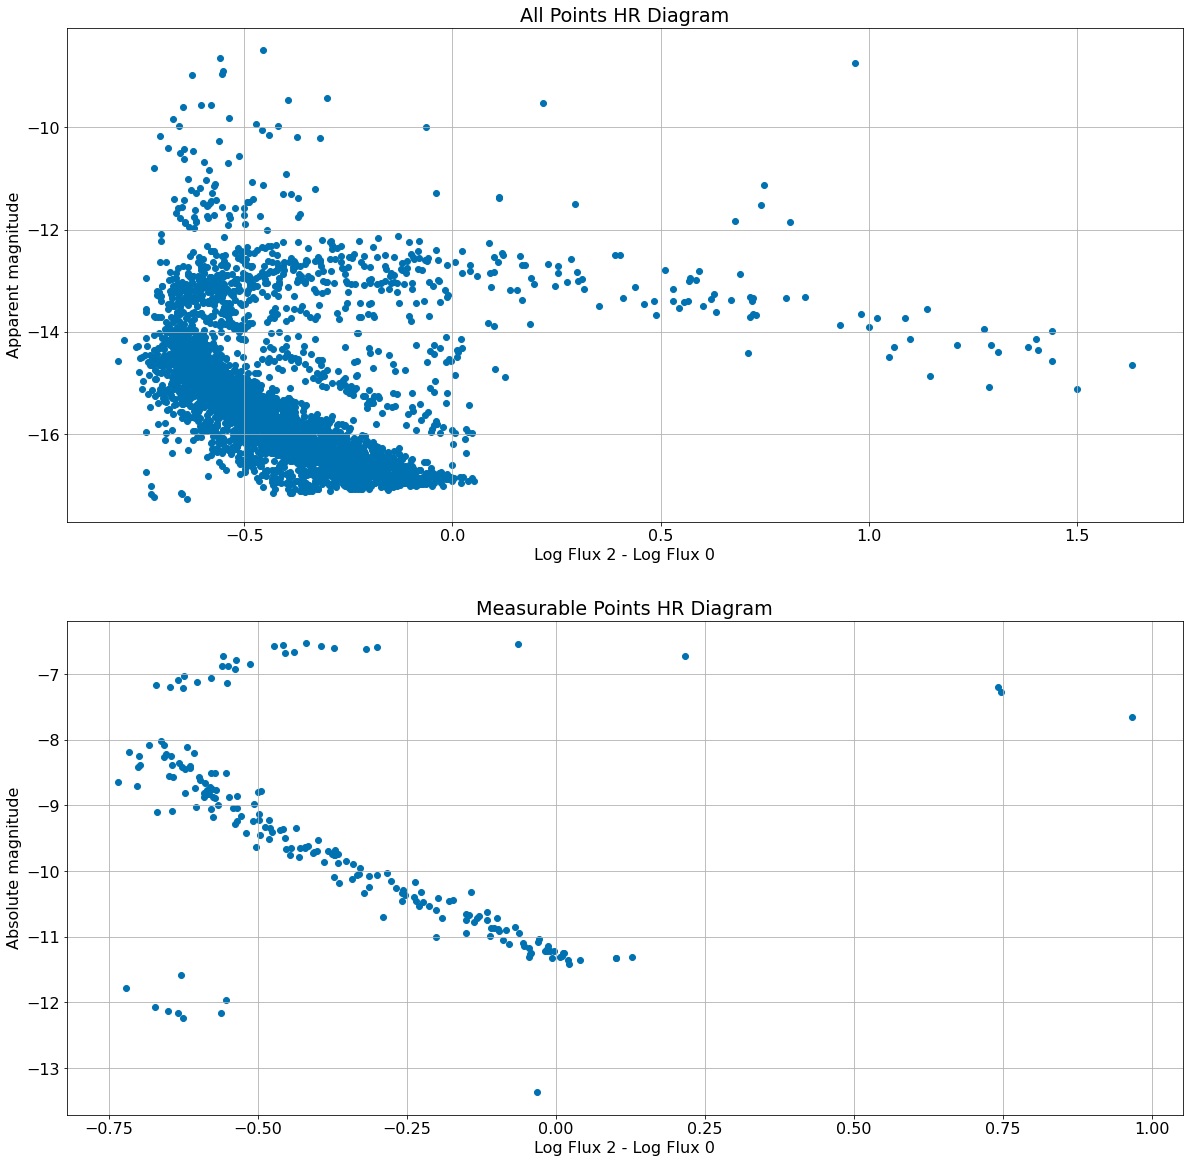

In [7]:
figApparentHR = plt.figure()
ax1 = figApparentHR.add_subplot(2, 1, 1)
allPoints_HRfloats=(np.concatenate((closePointsNumpy[:,[4,6]],midPointsNumpy[:,[4,6]],farPointsNumpy[:,[4,6]]))).astype(np.float)
# figure for HR diagram Template
plt.ylabel('Apparent magnitude')
plt.xlabel('Log Flux 2 - Log Flux 0')
plt.title('All Points HR Diagram')
plt.scatter((allPoints_HRfloats.T)[0].astype(np.float),(allPoints_HRfloats.T)[1].astype(np.float))
plt.grid()

ax2 = figApparentHR.add_subplot(2, 1, 2)
# MeasurablePoints_HRfloats=(np.concatenate((closePointsNumpy[:,[4,5]],midPointsNumpy[:,[4,5]]))).astype(np.float)
# figure for HR diagram Template
plt.ylabel('Absolute magnitude')
plt.xlabel('Log Flux 2 - Log Flux 0')
plt.title('Measurable Points HR Diagram')
# plt.scatter((MeasurablePoints_HRfloats.T)[0].astype(np.float),(MeasurablePoints_HRfloats.T)[1].astype(np.float))
plt.scatter((closePointsNumpy[:,4]).astype(np.float),(closePointsNumpy[:,5]).astype(np.float))
# plt.scatter((midPointsNumpy[:,4]).astype(np.float),(midPointsNumpy[:,5]).astype(np.float))
plt.grid()


### Unfolded sky map plot

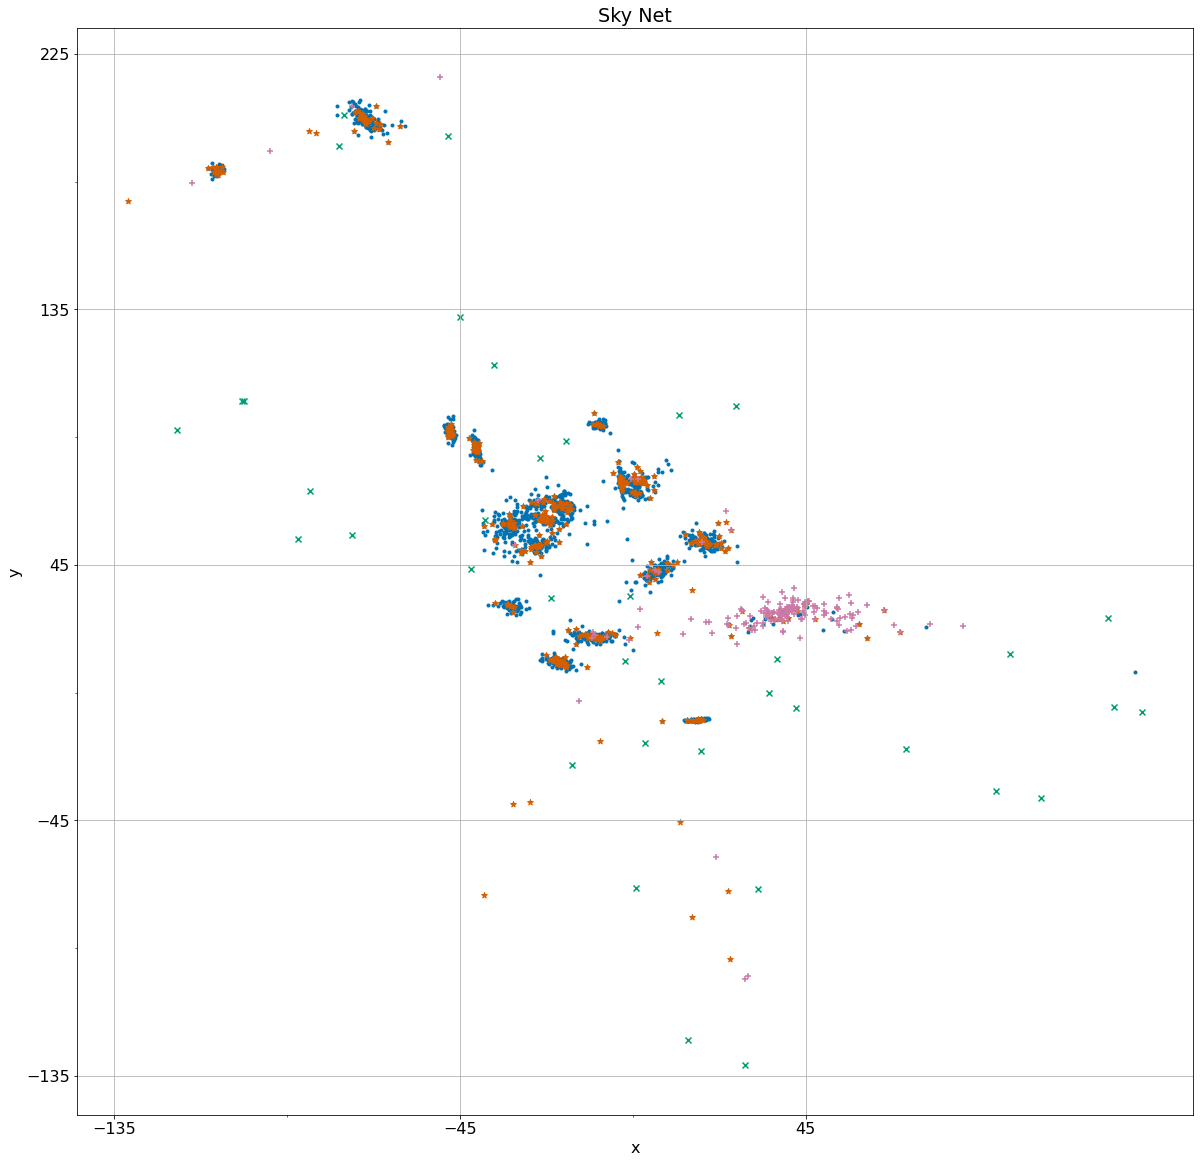

In [8]:
# figure for HR diagram benchmark
skyNet= plt.figure()
ax = skyNet.add_subplot(1, 1, 1)
plt.ylabel('y')
plt.xlabel('x')
plt.title('Sky Net')

plt.scatter((farPointsNumpy.T)[1].astype(np.float),(farPointsNumpy.T)[2].astype(np.float), marker = '.')
plt.scatter((xRayPointsNumpy.T)[0].astype(np.float),(xRayPointsNumpy.T)[1].astype(np.float), marker = 'x')
plt.scatter((variablePointsNumpy.T)[2].astype(np.float),(variablePointsNumpy.T)[3].astype(np.float), marker = '*')
plt.scatter((midPointsNumpy.T)[1].astype(np.float),(midPointsNumpy.T)[2].astype(np.float), marker = '+')


yticksMajor = [-135,-45,45,135,225]
yticksMinor = [-90,0,90,180]
xticksMajor = [-135,-45,45]
xticksMinor = [-90,0]

ax.set_xticks(xticksMajor)
ax.set_yticks(yticksMajor)
ax.set_xticks(xticksMinor, minor=True)
ax.set_yticks(yticksMinor, minor=True)
plt.grid()

### Pre processing
- transform HR diagram data so that y axis runs along main sequence length.

In [9]:
# BGMM parameters
clusterCount = 3   #initial clusterCount
countStep = 5
CountTrials = 3
WCP = 1            #weight_concentration_prior
MPR = 1            #mean_precision_prior
# loop with BGMM cluster algorithm and check when some weights go to 0.
clustersModel = (mixture.BayesianGaussianMixture(
                n_components=clusterCount,
                weight_concentration_prior=WCP,
                mean_precision_prior=MPR,
                covariance_type="full",
                n_init = CountTrials
                )).fit(closePointsNumpy[:,[4,5]].astype(np.float))    
clusterShapes = clustersModel.predict(closePointsNumpy[:,[4,5]].astype(np.float))

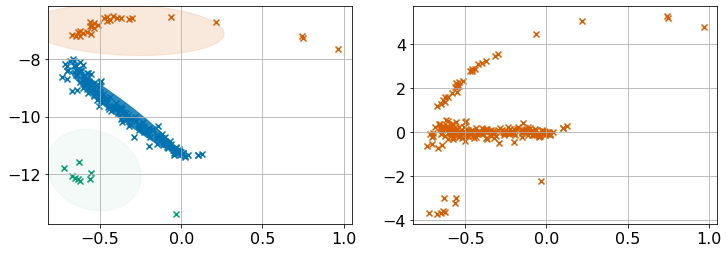

In [10]:
## initiate global variables for nested construction
matplotlib.rcParams['figure.figsize']=(12,4)  
colorCycle = itertools.cycle(sns.color_palette())
clusterPlots=[]
clusters=[]
gradient=[]
clusterPlot=mpl.pyplot.figure()
ax1 = clusterPlot.add_subplot(1, 2, 1)

## plot identified HR clusters
for i, (mean, cov, color, weights) in enumerate(zip(clustersModel.means_, clustersModel.covariances_, colorCycle, clustersModel.weights_)):

    
    v, w = sp.linalg.eigh(cov)
    if not np.any(clusterShapes == i) or weights<(0.01/clusterCount):
        continue
    clusters.append(closePointsNumpy[:,[4,5]][clusterShapes == i, :].astype(np.float))
    gradient.append(w[0][0]/ w[0][1])
    ### Sky map cluster plot
    plt.grid()
    plt.scatter(closePointsNumpy[:,4].astype(np.float)[clusterShapes == i], closePointsNumpy[:,5].astype(np.float)[clusterShapes == i], color= color, marker ='x')
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell1 = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell1.set_clip_box(ax1.bbox)
    ell1.set_alpha(weights)
    ax1.add_artist(ell1)

## get Main sequence to fit polynomial to
clusterSize=0
i=0
MSindex=0
for c in clusters:
    if len(c)>clusterSize:
        clusterSize=len(c)
        MSindex=i
    i=i+1
MSFit=np.poly1d(np.polyfit(clusters[MSindex][:,0],clusters[MSindex][:,1],2))    
x=closePointsNumpy[:,4].astype(np.float)
test=MSFit.c[1]
transformedMags=closePointsNumpy[:,5].astype(np.float)-np.square(x)*MSFit.c[0]-x*MSFit.c[1]-MSFit.c[2]
ax2 = clusterPlot.add_subplot(1, 2, 2)
plt.grid()
plt.scatter(x,transformedMags, color= color, marker ='x')

## Transform all points data
closePointsNumpy = np.c_[closePointsNumpy, closePointsNumpy[:,5].astype(np.float)-np.square(x)*MSFit.c[0]-x*MSFit.c[1]-MSFit.c[2]]
midPointsNumpy = np.c_[midPointsNumpy, midPointsNumpy[:,6].astype(np.float)-np.square(midPointsNumpy[:,4].astype(np.float))*MSFit.c[0]-midPointsNumpy[:,4].astype(np.float)*MSFit.c[1]-MSFit.c[2]]
farPointsNumpy = np.c_[farPointsNumpy, farPointsNumpy[:,6].astype(np.float)-np.square(farPointsNumpy[:,4].astype(np.float))*MSFit.c[0]-farPointsNumpy[:,4].astype(np.float)*MSFit.c[1]-MSFit.c[2]]
    

## Cluster processing

Process:
- Use x, y, HRx and HRy in a Bayesian Gaussian mixture model (BGMM) clustering with parallaxable points serving as an informative prior for the BGMM.

    - If any of the sky map clusters don't have a max density (or close too) at the mean xy position, increase weight_concentration_prior and iterate.
    - check fit of cluster onto regressed gaussian in sky map, if fit is below threshold, increase 

In [11]:
# BGMM parameters
clusterCount = 1   #initial clusterCount
countStep = 5
CountTrials = 10
WCP = 1            #weight_concentration_prior
MPR = 1            #mean_precision_prior
# Data for BGMM pror
clusterPrior=closePointsNumpy[:,[1,2,4,5]].astype(np.float)
# Data for BGMM
farPoints_floats=np.concatenate([farPointsNumpy[:,[1,2,4,6,7,8]], midPointsNumpy[:,[1,2,4,6,7,8]]]).astype(np.float)

# loop with BGMM cluster algorithm and check when some weights go to 0.
clustersModel = (mixture.BayesianGaussianMixture(
                n_components=clusterCount,
                weight_concentration_prior=WCP,
                mean_precision_prior=MPR,
                covariance_type="full",
                n_init = CountTrials
                )).fit(farPoints_floats[:,[0,1]])
while min(clustersModel.weights_)>(0.01/clusterCount):
    
    clusterCount=clusterCount+countStep
    
    clustersModel = (mixture.BayesianGaussianMixture(
                    n_components=clusterCount,
                    weight_concentration_prior=WCP, 
                    mean_precision_prior=MPR, covariance_type="full",
                    n_init = CountTrials
                    )).fit(farPoints_floats[:,[0,1]])

clusterShapes = clustersModel.predict(farPoints_floats[:,[0,1]])


### Plot Skymap and HR diagram Clustering

### Individual Cluster Plots

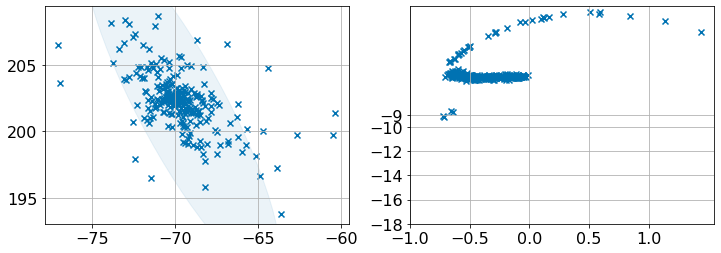

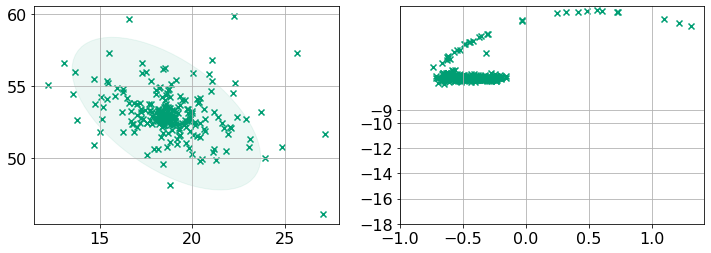

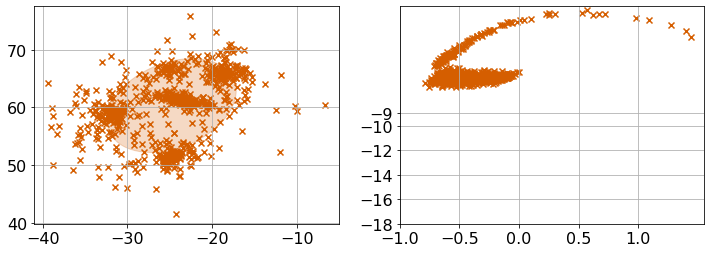

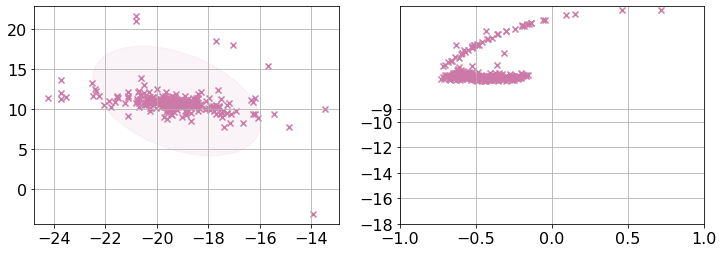

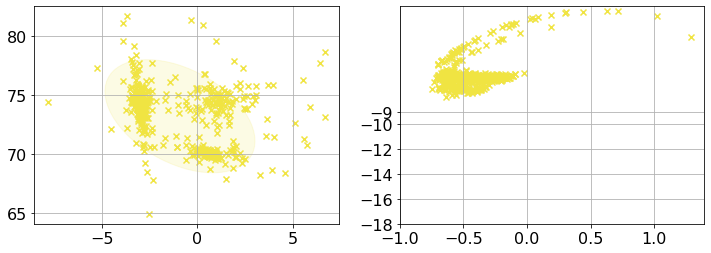

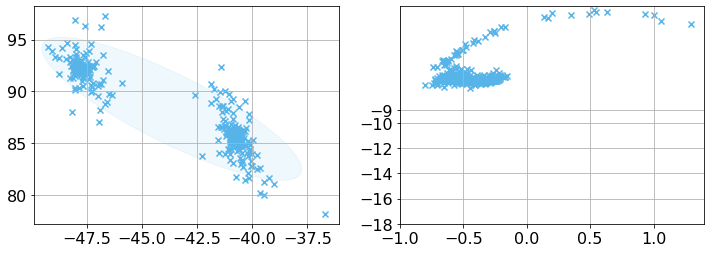

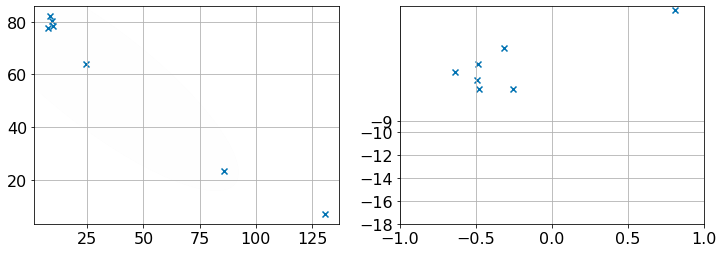

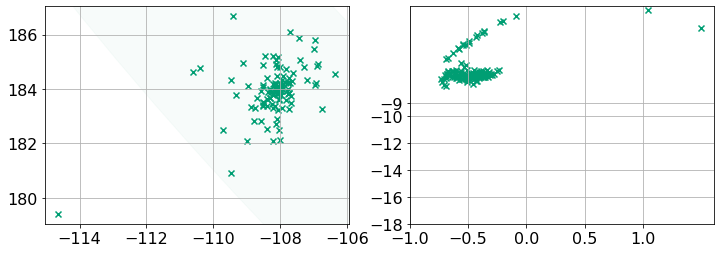

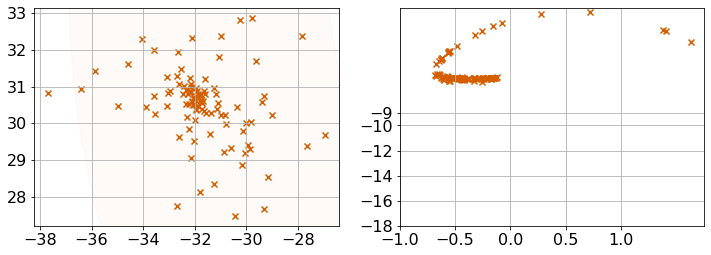

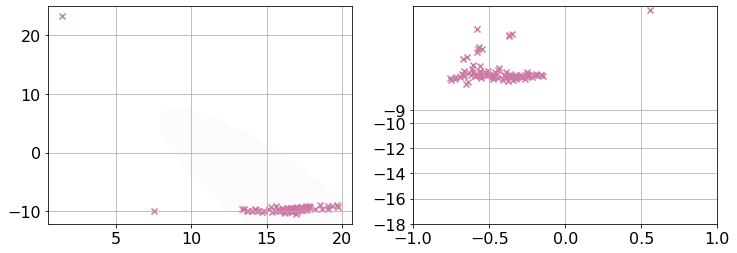

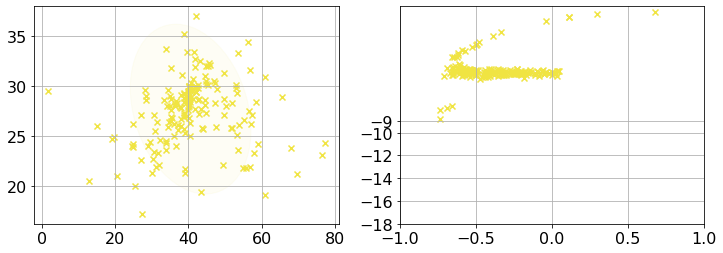

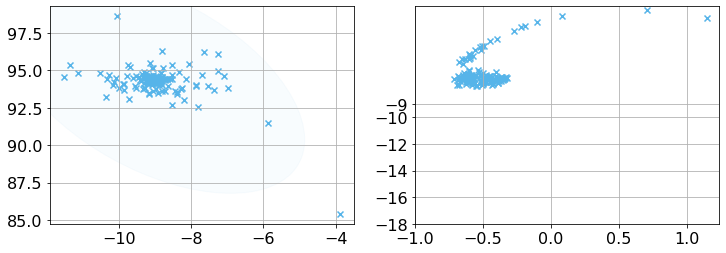

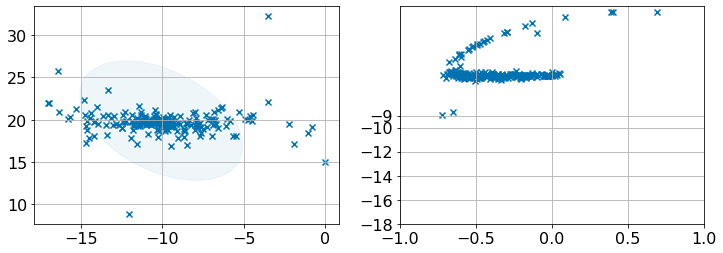

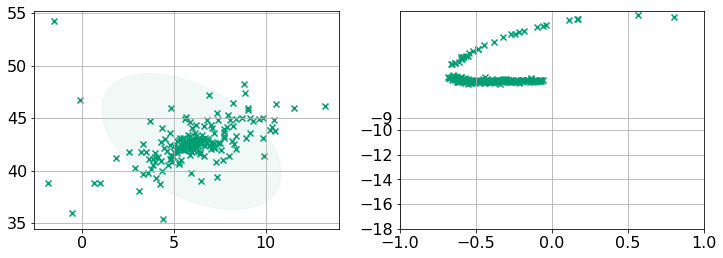

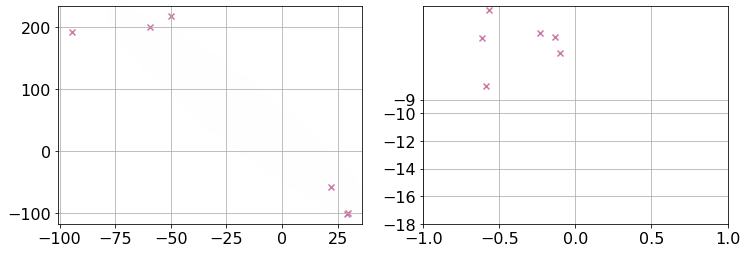

In [12]:
# Plot the Skymap Contours
matplotlib.rcParams['figure.figsize']=(12,4)  
colorCycle = itertools.cycle(sns.color_palette())
clusterPlots=[]
clusters=[]
for i, (mean, cov, color, weights) in enumerate(zip(clustersModel.means_, clustersModel.covariances_, colorCycle, clustersModel.weights_)):

    
    v, w = sp.linalg.eigh(cov)
    if not np.any(clusterShapes == i) or weights<(0.01/clusterCount):
        continue
    clusterPlots.append(mpl.pyplot.figure())
    clusters.append(farPoints_floats[clusterShapes == i, :])
    ### Sky map cluster plot
    ax1 = clusterPlots[-1].add_subplot(1, 2, 1)
    plt.grid()
    plt.scatter(farPoints_floats[clusterShapes == i, 0], farPoints_floats[clusterShapes == i, 1], color= color, marker ='x')
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell1 = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell1.set_clip_box(ax1.bbox)
    ell1.set_alpha(weights)
    ax1.add_artist(ell1)
    
    ### HR diagram cluster plot
    ax2 = clusterPlots[-1].add_subplot(1, 2, 2)
    plt.grid()
    mpl.pyplot.scatter(farPoints_floats[clusterShapes == i, 2], farPoints_floats[clusterShapes == i, 5], marker = 'x', color=color)
    # Plot an ellipse to show the Gaussian component
#     angle = np.arctan2(w[2][1], w[2][0])
#     angle = 180.0 * angle / np.pi  # convert to degrees
#     v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
#     ell2 = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
#     ell2.set_clip_box(ax2.bbox)
#     ell2.set_alpha(weights)
#     ax2.add_artist(ell2)
    
    yticksMajor = [-18,-16,-14,-12,-10,-9]
    xticksMajor = [-1,-0.5,0,0.5,1]

    ax2.set_xticks(xticksMajor)
    ax2.set_yticks(yticksMajor)

plt.show()   

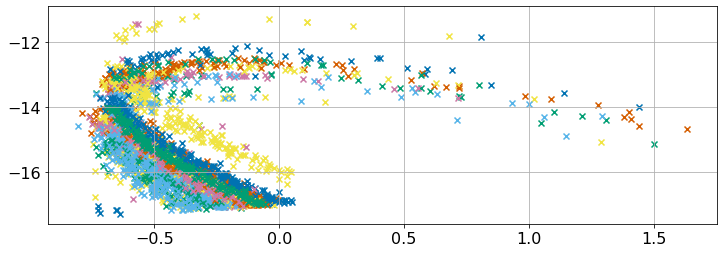

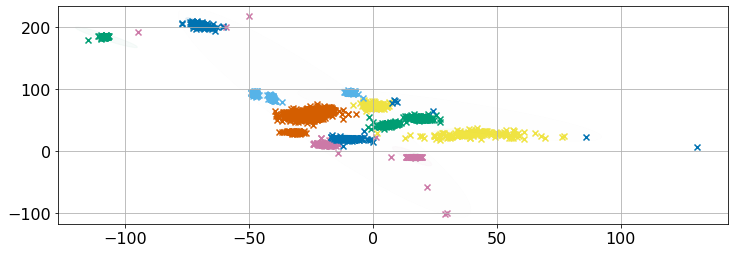

In [13]:
# Plot the Skymap Contours
ClusterFitSkyPlot= mpl.pyplot.figure()
ax = ClusterFitSkyPlot.add_subplot(1, 1, 1)
HRFitPlot= mpl.pyplot.figure()
HRax = HRFitPlot.add_subplot(1, 1, 1)
colorCycle = itertools.cycle(sns.color_palette())
for i, (mean, cov, color, weights) in enumerate(zip(clustersModel.means_, clustersModel.covariances_, colorCycle, clustersModel.weights_)):
    v, w = sp.linalg.eigh(cov)
    if not np.any(clusterShapes == i) or weights<(0.01/clusterCount):
        continue
    mpl.pyplot.figure(ClusterFitSkyPlot)
    mpl.pyplot.sca(ax)
    plt.scatter(farPoints_floats[clusterShapes == i, 0], farPoints_floats[clusterShapes == i, 1], color= color, marker ='x')
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(weights)
    ax.add_artist(ell)
    
    mpl.pyplot.figure(HRFitPlot)
    mpl.pyplot.sca(HRax)
    mpl.pyplot.scatter(farPoints_floats[clusterShapes == i, 2], farPoints_floats[clusterShapes == i, 3], marker = 'x', color=color)
    # Plot an ellipse to show the Gaussian component
    # angle = np.arctan2(w[2][1], w[2][0])
    # angle = 180.0 * angle / np.pi  # convert to degrees
    # v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    # ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    # ell.set_clip_box(HRax.bbox)
    # ell.set_alpha(weights)
    # HRax.add_artist(ell)
    
plt.grid()
mpl.pyplot.figure(ClusterFitSkyPlot)
mpl.pyplot.sca(ax)
plt.grid()
plt.show()   

### check for and separate tight clusters

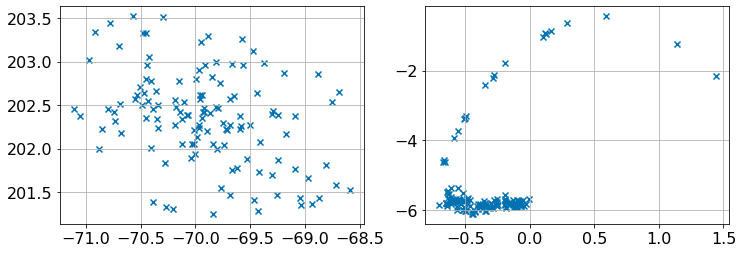

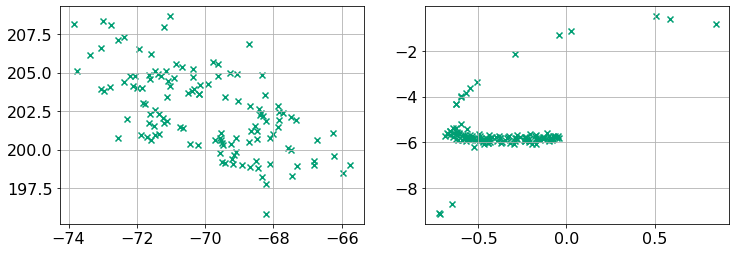

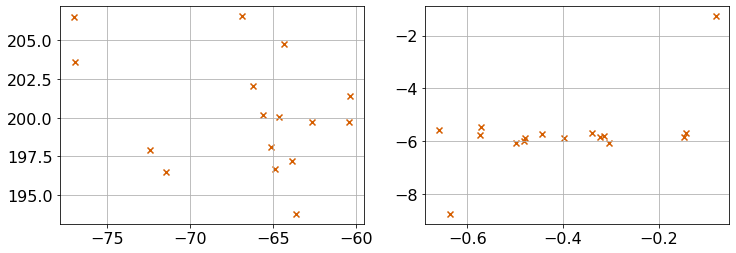

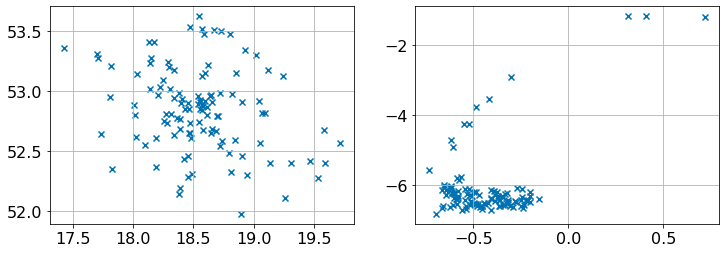

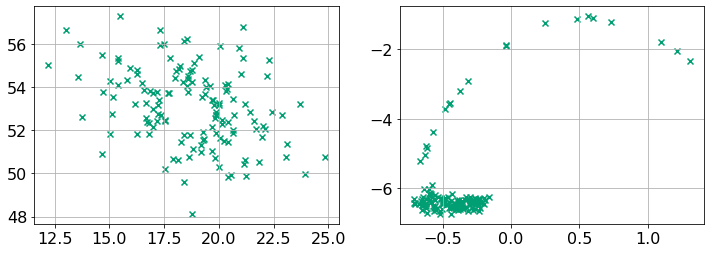

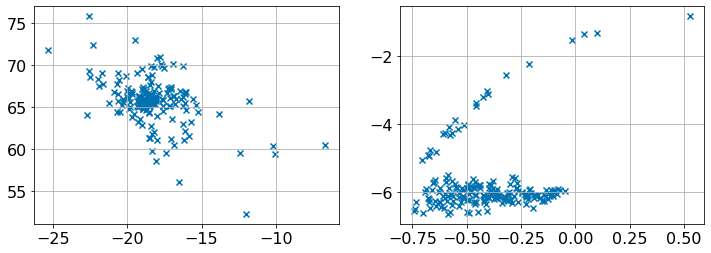

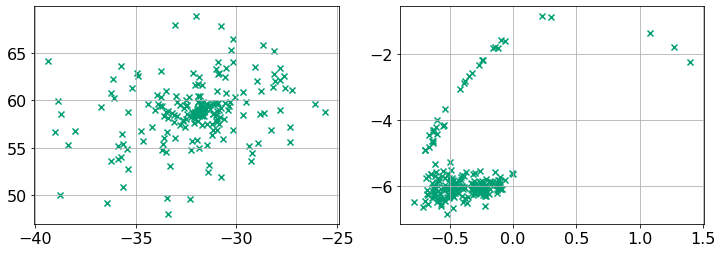

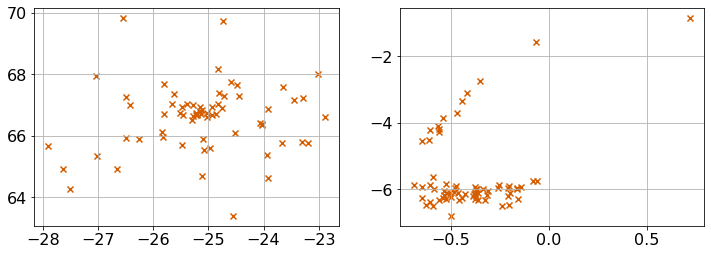

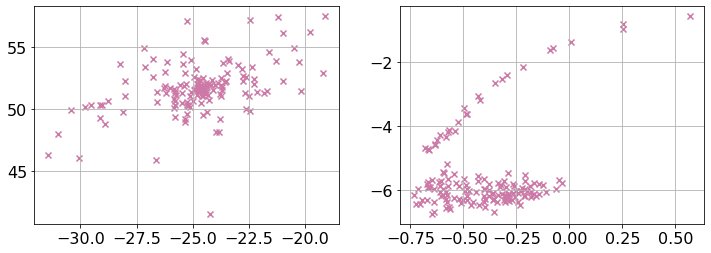

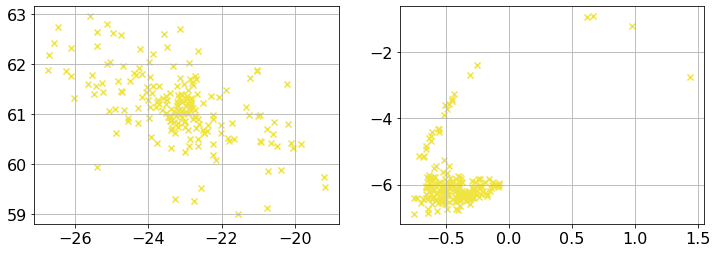

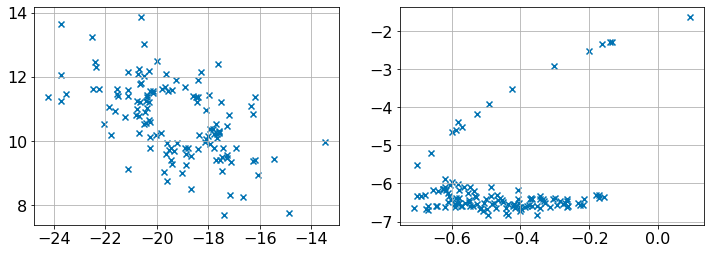

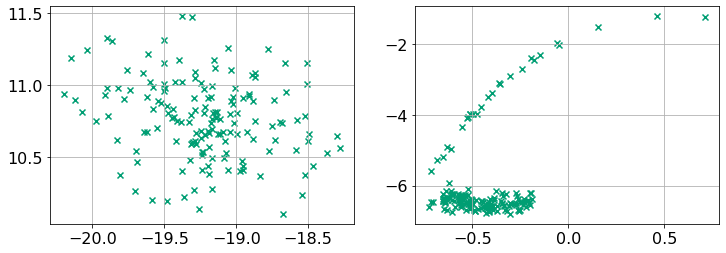

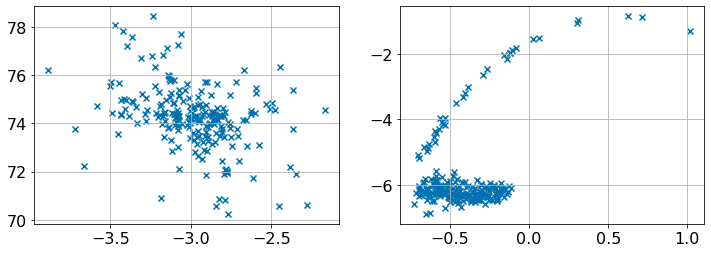

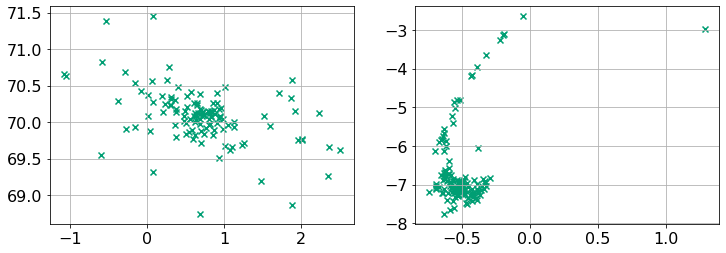

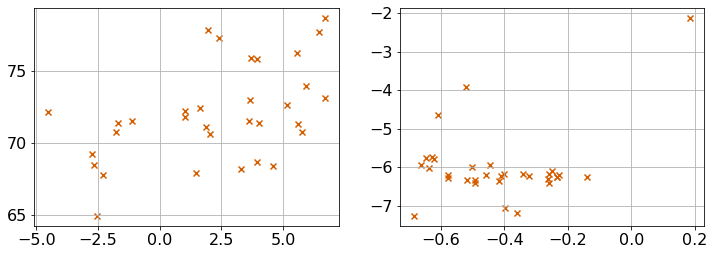

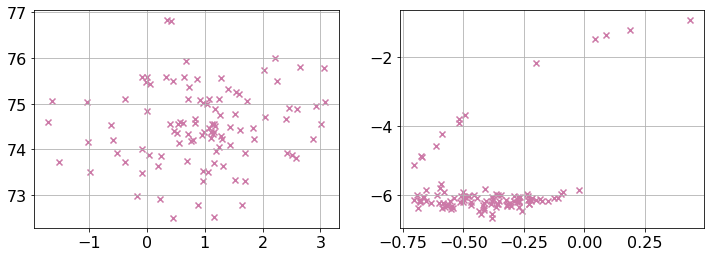

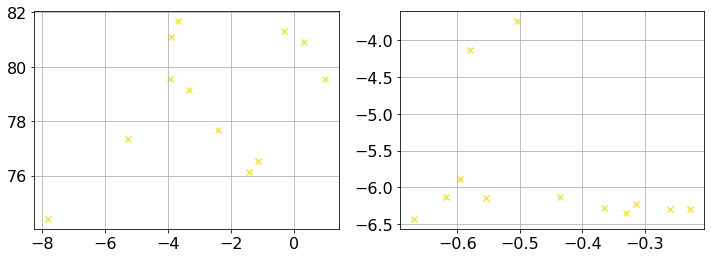

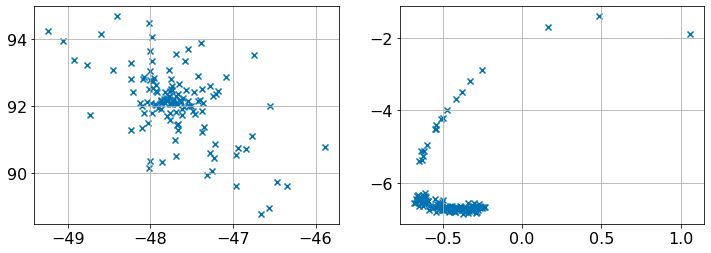

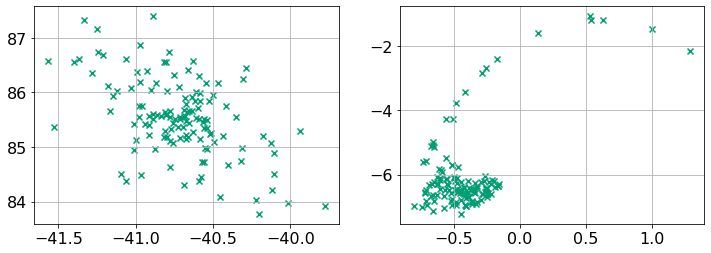

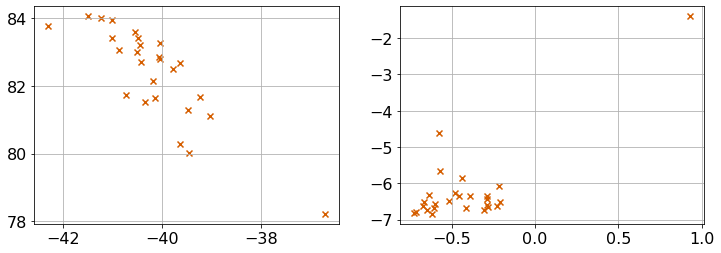

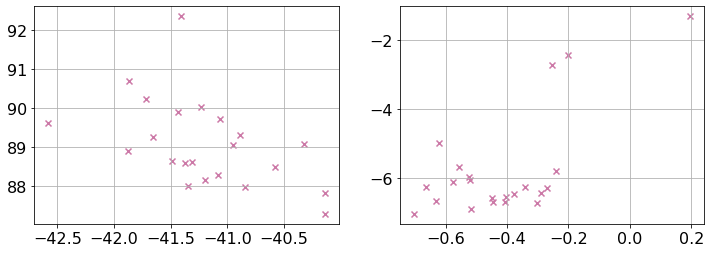

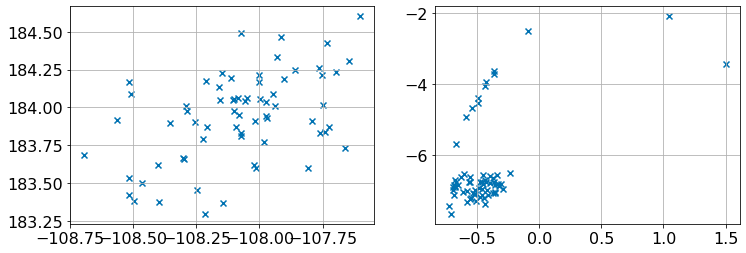

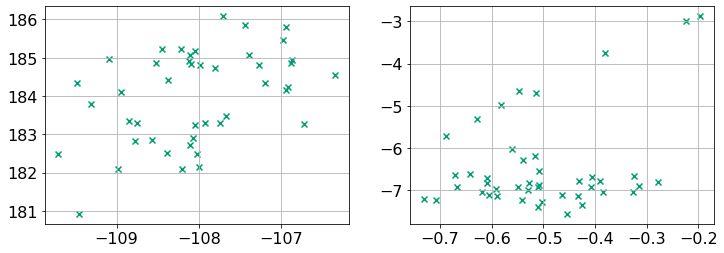

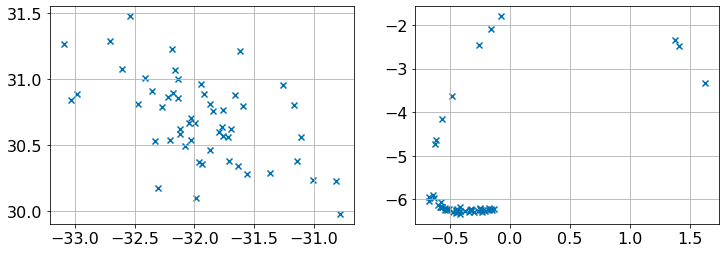

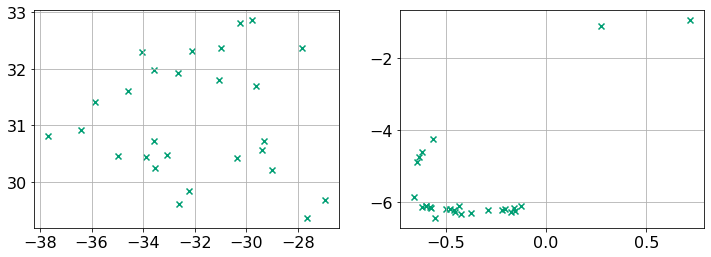

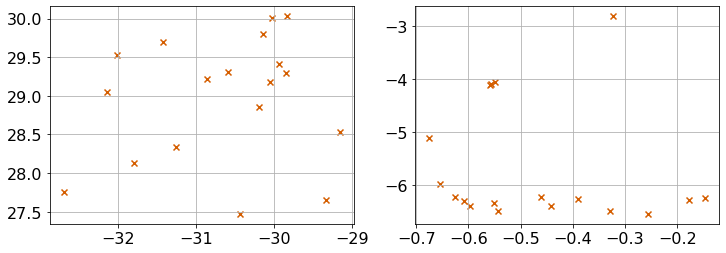

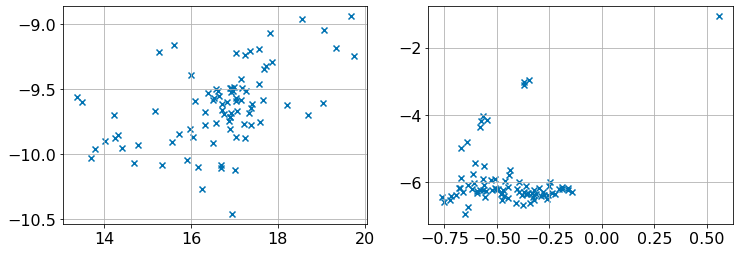

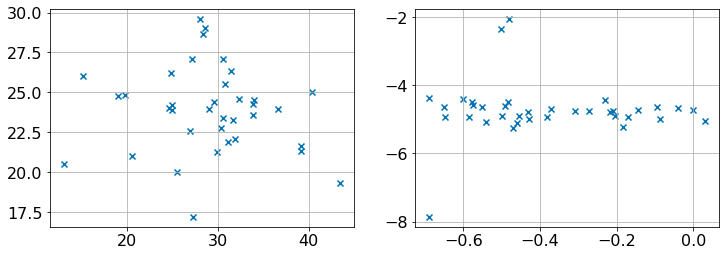

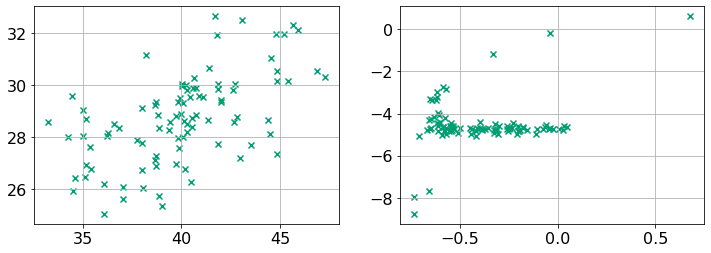

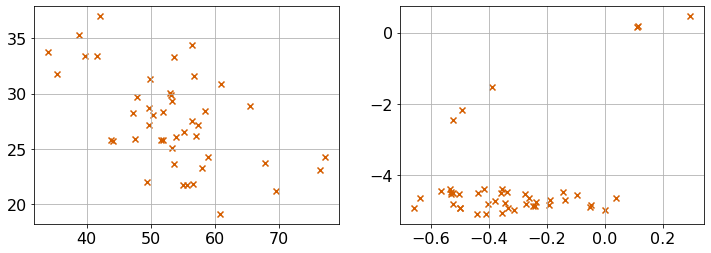

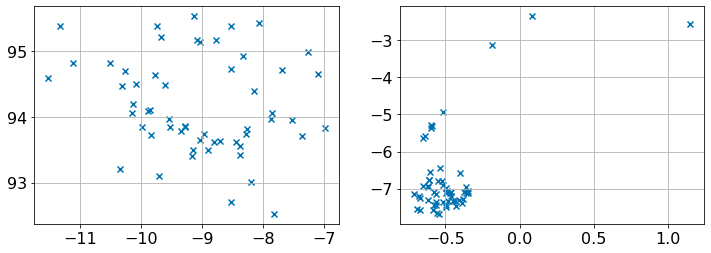

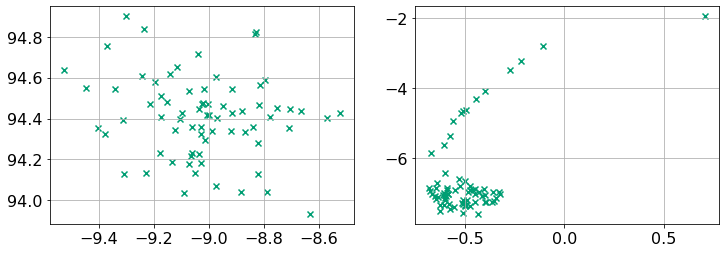

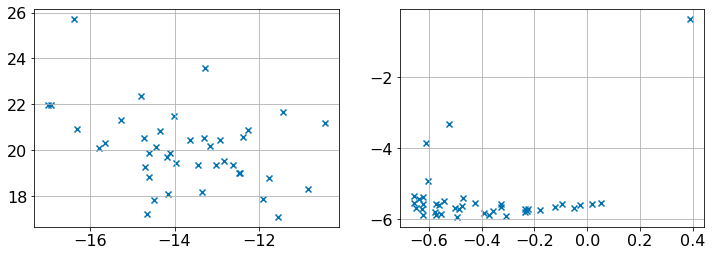

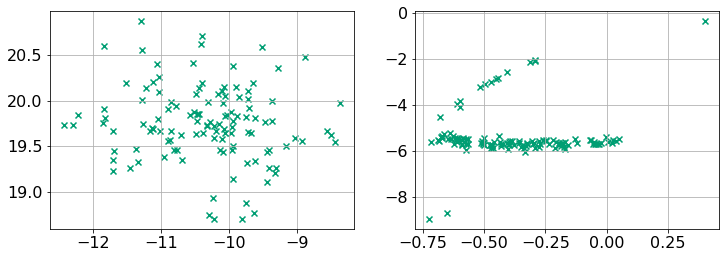

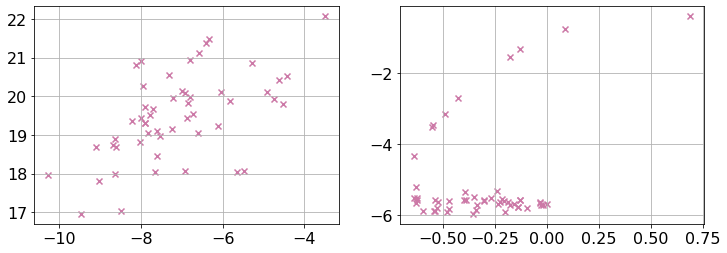

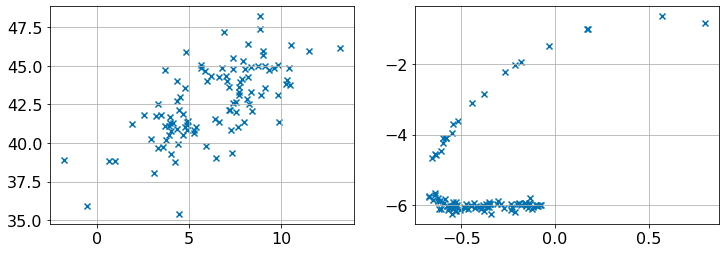

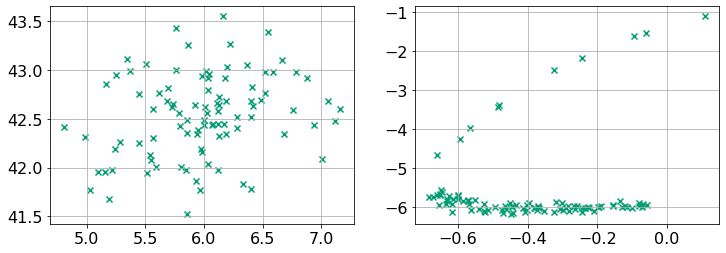

In [14]:
for cluster in clusters:
    # BGMM parameters
    clusterCount = 5   #initial clusterCount
    countStep = 5
    CountTrials = 5
    WCP = 1            #weight_concentration_prior
    MPR = 1            #mean_precision_prior

    ## try splitting curent cluster into smaller clusters
    clustersModel = (mixture.BayesianGaussianMixture(
                    n_components=clusterCount,
                    weight_concentration_prior=WCP,
                    mean_precision_prior=MPR,
                    covariance_type="full",
                    n_init = CountTrials
                    )).fit(cluster[:,[0,1]])
    subClusterShapes = clustersModel.predict(cluster[:,[0,1]])    
    # Plot the Skymap Contours
    colorCycle = itertools.cycle(sns.color_palette())
    subClusterPlots=[]
    subClusters=[]
    for i, (mean, cov, color, weights) in enumerate(zip(clustersModel.means_, clustersModel.covariances_, colorCycle, clustersModel.weights_)):
        if not np.any(subClusterShapes == i) or weights<(0.01/clusterCount) or len(cluster[subClusterShapes == i, :])<10 :
            continue
        subClusterPlots.append(mpl.pyplot.figure())
        subClusters.append(cluster[subClusterShapes == i, :])

        ### Sky map cluster plot
        ax1 = subClusterPlots[-1].add_subplot(1, 2, 1)
        plt.grid()
        plt.scatter(cluster[subClusterShapes == i, 0], cluster[subClusterShapes == i, 1], color= color, marker ='x')
        ### HR diagram cluster plot
        ax2 = subClusterPlots[-1].add_subplot(1, 2, 2)
        plt.grid()
        mpl.pyplot.scatter(cluster[subClusterShapes == i, 2], cluster[subClusterShapes == i, 5], marker = 'x', color=color)

    plt.show()   

## Recombine cluster sections

- compare means and main branch position of clusters. If to close by stat method to be different, combine.